In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [20]:
dataset=pd.read_csv('/content/Consumer_Complaints.csv', engine='python', on_bad_lines='skip')

In [21]:
dataset.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,3/12/2014,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,M&T BANK CORPORATION,MI,48382,NaN,NaN,Referral,3/17/2014,Closed with explanation,Yes,No,759217
1,10/1/2016,Credit reporting,NaN,Incorrect information on credit report,Account status,I have outdated information on my credit repor...,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",AL,352XX,NaN,Consent provided,Web,10/5/2016,Closed with explanation,Yes,No,2141773
2,10/17/2016,Consumer Loan,Vehicle loan,Managing the loan or lease,NaN,I purchased a new car on XXXX XXXX. The car de...,NaN,"CITIZENS FINANCIAL GROUP, INC.",PA,177XX,Older American,Consent provided,Web,10/20/2016,Closed with explanation,Yes,No,2163100
3,6/8/2014,Credit card,NaN,Bankruptcy,NaN,NaN,NaN,AMERICAN EXPRESS COMPANY,ID,83854,Older American,NaN,Web,6/10/2014,Closed with explanation,Yes,Yes,885638
4,9/13/2014,Debt collection,Credit card,Communication tactics,Frequent or repeated calls,NaN,NaN,"CITIBANK, N.A.",VA,23233,NaN,NaN,Web,9/13/2014,Closed with explanation,Yes,Yes,1027760


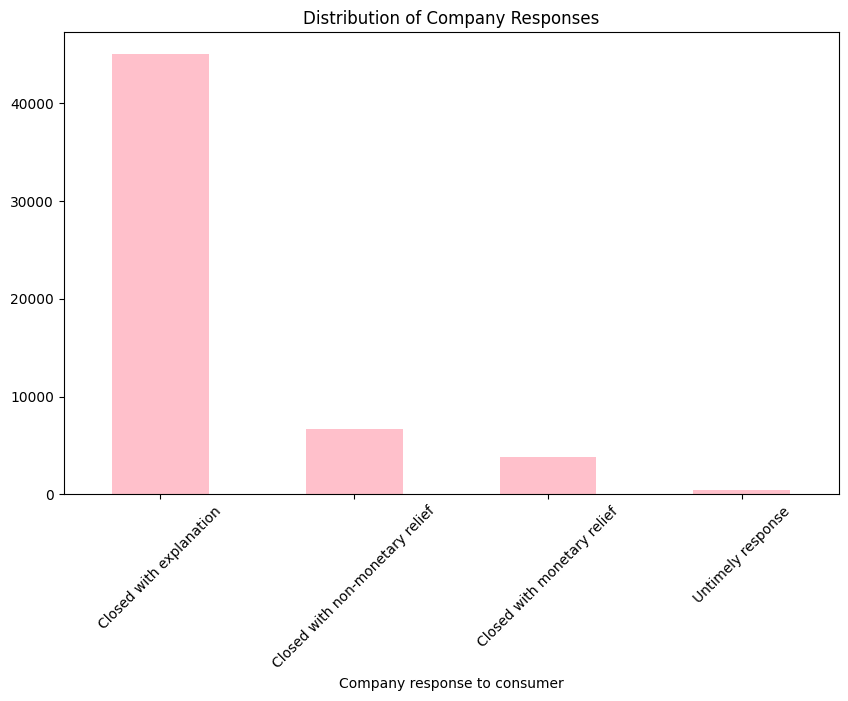

In [44]:
plt.figure(figsize=(10, 6))
dataset['Company response to consumer'].value_counts().plot(kind='bar',color='pink')
plt.title('Distribution of Company Responses')
plt.xticks(rotation=45)
plt.show()

In [23]:
dataset = dataset[['Complaint ID', 'Company response to consumer','Consumer complaint narrative']]
display(dataset.head())

,Complaint ID,Company response to consumer,Consumer complaint narrative
0,759217,Closed with explanation,NaN
1,2141773,Closed with explanation,I have outdated information on my credit repor...
2,2163100,Closed with explanation,I purchased a new car on XXXX XXXX. The car de...
3,885638,Closed with explanation,NaN
4,1027760,Closed with explanation,NaN


In [24]:
print(dataset[[ 'Complaint ID', 'Company response to consumer']].isnull().sum())

Complaint ID                    0
Company response to consumer    0
dtype: int64


In [25]:
response_mapping = {
    'Closed with explanation': 1,
    'Closed with non-monetary relief': 0,
    'Closed with relief': 1,              # Solved
    'Closed with monetary relief': 1,     # Solved
    'Untimely response': 0    ,
    'Closed ': 1,
       'Closed without relief': 0


}
dataset['is_solved'] = dataset['Company response to consumer'].map(response_mapping)
dataset=dataset.dropna(subset=['is_solved'])

In [26]:
import re
dataset['Consumer complaint narrative']=dataset['Consumer complaint narrative'].str.replace(r'[^a-zA-Z\s]', '', regex=True)

In [27]:
dataset['Consumer complaint narrative']=dataset['Consumer complaint narrative'].str.lower()

In [28]:
dataset.head()

,Complaint ID,Company response to consumer,Consumer complaint narrative,is_solved
0,759217,Closed with explanation,NaN,1.0
1,2141773,Closed with explanation,i have outdated information on my credit repor...,1.0
2,2163100,Closed with explanation,i purchased a new car on xxxx xxxx the car dea...,1.0
3,885638,Closed with explanation,NaN,1.0
4,1027760,Closed with explanation,NaN,1.0


In [29]:
dataset=dataset.dropna(subset=['Consumer complaint narrative']).copy()
display(dataset.head())

,Complaint ID,Company response to consumer,Consumer complaint narrative,is_solved
1,2141773,Closed with explanation,i have outdated information on my credit repor...,1.0
2,2163100,Closed with explanation,i purchased a new car on xxxx xxxx the car dea...,1.0
7,1420702,Closed with explanation,an account on my credit report has a mistaken ...,1.0
12,1772196,Closed with explanation,this company refuses to provide me verificatio...,1.0
16,1790634,Closed with explanation,this complaint is in regards to square two fin...,1.0


In [30]:
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [31]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

In [32]:
def preprocess(text):
  tokens=text.split()
  tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]

  return ' '.join(tokens)


In [33]:
dataset['cleaned_text'] = dataset['Consumer complaint narrative'].apply(preprocess)

In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))

X = tfidf.fit_transform(dataset['cleaned_text']).toarray()

y = dataset['is_solved'].values

print(f"Feature matrix shape: {X.shape}")

Feature matrix shape: (55989, 5000)


In [35]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

print(pd.Series(y_resampled).value_counts())

1.0    48854
0.0    48854
Name: count, dtype: int64


In [36]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

model = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
model.fit(X_train, y_train)


y_pred = model.predict(X_test)

              precision    recall  f1-score   support

         0.0       0.76      0.80      0.78      9771
         1.0       0.79      0.74      0.77      9771

    accuracy                           0.77     19542
   macro avg       0.77      0.77      0.77     19542
weighted avg       0.77      0.77      0.77     19542



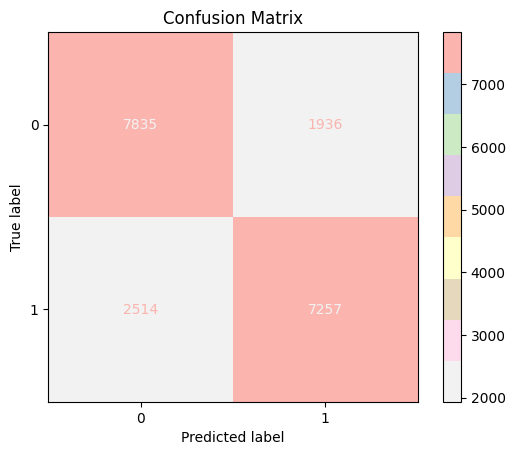

In [43]:
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Pastel1_r')
plt.title('Confusion Matrix')
plt.show()